# XYG3 型泛函核坐标梯度与核坐标梯度 CheatSheet

这一节我们会先简单讨论 XYG3 核坐标梯度的计算方式；随后完整地从程序上完整地整理一遍核坐标梯度的编写过程。这一节希望这里的内容也可以作为能快速翻阅查找具体矩阵或张量计算方法的工具。

## 准备工作

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib, grad, hessian
from pyscf.scf import cphf
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff, GridHelper, KernelHelper
from pyxdh.DerivOnce import GradSCF, GradMP2, GradXDH

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
def mol_to_grids(mol, atom_grid=(75, 302)):
    grids = dft.Grids(mol)
    grids.atom_grid = atom_grid
    grids.becke_scheme = dft.gen_grid.stratmann
    grids.prune = None
    grids.build()
    return grids
grids = mol_to_grids(mol)

我们知道 XYG3 分为自洽场部分与非自洽部分；其自洽场部分使用 B3LYP 泛函导出电子态密度 $D_{\mu \nu}$，进而代入密度到非自洽部分。因此，我们需要有自洽场与非自洽两个计算实例。其中，B3LYP 的自洽场实例就与以前定义的方式相同：

In [4]:
def mol_to_scf(mol):
    scf_eng = dft.RKS(mol)
    scf_eng.grids = mol_to_grids(mol)
    scf_eng.xc = "B3LYPg"
    scf_eng.conv_tol = 1e-10
    return scf_eng.run()

而非自洽部分则定义为 XYG3 除开 PT2 部分贡献之外的泛函，但该计算实例不应通过自洽场运算 (即运行 `.run` 成员函数)：

In [5]:
def mol_to_nc(mol):
    nc_eng = dft.RKS(mol)
    nc_eng.grids = mol_to_grids(mol)
    nc_eng.xc = "0.8033*HF - 0.0140*LDA + 0.2107*B88, 0.6789*LYP"
    nc_eng.conv_tol = 1e-10
    return nc_eng

XYG3 型泛函所使用的梯度计算类是 `GradXDH`；它所必须需要的输入参数是 `scf_eng` 自洽场运算实例与 `nc_eng` 非自洽运算实例：

In [6]:
scf_eng = mol_to_scf(mol)
nc_eng = mol_to_nc(mol)
gradh = GradXDH({"scf_eng": scf_eng, "nc_eng": nc_eng, "cphf_tol": 1e-12})

与自洽场有关的各种矩阵会定义如下：

In [7]:
nmo, nao, natm, nocc, nvir, cx, cc = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir, gradh.cx, gradh.cc
mol_slice = gradh.mol_slice
so, sv, sa = gradh.so, gradh.sv, gradh.sa
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo
T_iajb, t_iajb, D_iajb = gradh.T_iajb, gradh.t_iajb, gradh.D_iajb

注意到上面是自洽场过程给出的结果；而对于非自洽部分，我们需要非自洽交换积分系数 `cx_n` $c_\mathrm{x}^\mathrm{n}$：

In [8]:
cx_n = gradh.nc_deriv.cx
cx_n

0.8033

对于自洽或非自洽过程，原子轨道或涉及到密度的、核坐标梯度的格点都是相同的：

In [9]:
grdh = GridHelper(mol, grids, D)
ao_0, ao_1, ao_2 = grdh.ao_0, grdh.ao_1, grdh.ao_2
rho_0, rho_1, rho_2 = grdh.rho_0, grdh.rho_1, grdh.rho_2

但涉及到泛函核的部分，我们就需要区分对待了。`kerh` 储存的是自洽泛函即 B3LYP 的泛函核格点，`kerh_n` 储存的是非自洽部分的泛函核格点。

In [10]:
kerh = KernelHelper(grdh, "B3LYPg")
kerh_n = KernelHelper(grdh, "0.8033*HF - 0.0140*LDA + 0.2107*B88, 0.6789*LYP")

最后我们给出 XYG3 用于数值求导的实例：

In [11]:
def grad_generator(mol):
    return GradXDH({"scf_eng": mol_to_scf(mol), "nc_eng": mol_to_nc(mol), "cphf_tol": 1e-12})
gradn = NucCoordDerivGenerator(mol, grad_generator)

由于这一节的特殊性，我们特定一个函数用于绘制数值与解析矩阵之间的差距：

In [12]:
def plot_diff(anal_mat, num_mat):
    fig, ax = plt.subplots(figsize=(2.4, 1.8)); ax.set_xscale("log")
    ax.hist(abs(anal_mat.ravel() - num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    ax.hist(abs(num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    return fig.tight_layout()

## XYG3 型核坐标梯度：与 B2PLYP 型梯度的差异

### XYG3 能量

我们首先回顾一下 XYG3 能量的计算：

$$
E = h_{\mu \nu} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{c_\mathrm{x}^\mathrm{n}}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} + f^\mathrm{n} \rho + T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab} + E_\mathrm{nuc}
$$

In [13]:
(
    + np.einsum("uv, uv -> ", H_0_ao, D)
    + 0.5 * np.einsum("uv, uvkl, kl -> ", D, eri0_ao, D)
    - 0.25 * cx_n * np.einsum("uv, ukvl, kl -> ", D, eri0_ao, D)
    + np.einsum("g, g -> ", kerh_n.exc, rho_0)
    + np.einsum("iajb, iajb, iajb -> ", T_iajb, t_iajb, D_iajb)
    + gradh.scf_eng.energy_nuc()
)

-151.39095860684597

我们注意到，上述计算中，$h_{\mu \nu}, (\mu \nu | \kappa \lambda), E_\mathrm{nuc}$ 为分子构型决定量，$D_{\mu \nu}, \rho, D_{ij}^{ab}, t_{ij}^{ab}$ 来自于自洽场计算或其导出量，$c_\mathrm{x}, T_{ij}^{ab}, f^\mathrm{n}$ 是非自洽导出量。若我们要求取梯度时，其余的量都可以参考 B2PLYP 的做法；但涉及到非自洽过程的量就需要额外注意。

### XYG3 核坐标梯度：理论讨论

我们需要先对 XYG3 能量作拆分，其中的 GGA 部分能量记为

$$
E_\mathrm{GGA} = h_{\mu \nu} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{c_\mathrm{x}^\mathrm{n}}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} + f^\mathrm{n} \rho
$$

其 Skeleton 导数与 U 导数我们就仿照以前的文档进行处理，可以得到

$$
\partial_{A_t} E_\mathrm{GGA} \xleftarrow{\text{Skeleton derivative}} h_{\mu \nu}^{A_t} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda)^{A_t} D_{\kappa \lambda} - \frac{c_\mathrm{x}^\mathrm{n}}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda)^{A_t} D_{\kappa \lambda} + f_\rho^\mathrm{n} \rho^{A_t} + f_\gamma^\mathrm{n} \gamma_r^{A_t}
 $$

U 导数则为

$$
\partial_{A_t} E_\mathrm{GGA} \xleftarrow{\text{U derivative}} 4 F_{pi}^\mathrm{n} U_{pi}^{A_t} = - 2 S_{ij}^{A_t} F_{ij}^\mathrm{n} + 4 F_{ai}^\mathrm{n} U_{ai}^{A_t}
$$

我们曾经提到过，对于 Canonical SCF 方法，Fock 矩阵是对角矩阵；但对于非自洽泛函而言，由于轨道系数并非是通过 Fock 对角化得到，因而 $F_{pq}^\mathrm{n}$ 也显然未必是对角矩阵，即使它仍然具有对称的性质。那么，$F_{ai}^\mathrm{n}$ 也就是非零的，因此 GGA 的 U 导数部分比起之前文档中，似乎多了 $4 F_{ai}^\mathrm{n} U_{ai}^\mathrm{n}$ 的贡献。

随后，我们考虑 PT2 部分的能量导数。尽管 $T_{ij}^{ab}$ 确实包含了非自洽的贡献，但也仅限于相关系数 $c_\mathrm{c}^\mathrm{n}$；因此我们求取 PT2 部分能量的导数比起 B2PLYP 来没有实质变化：

$$
\partial_{A_t} E_\mathrm{PT2} = D_{pq}^\mathrm{PT2} B_{pq}^{A_t} + W_{pq}^\mathrm{PT2} [\mathrm{I}] S_{pq}^{A_t} + 2 T_{ij}^{ab} (ia|jb)^{A_t}
$$

但这里我们需要作补充。我们知道，$D_{ai}^\mathrm{PT2}$ 是通过 Z-Vector 方法给出的，$D_{ai}^\mathrm{PT2} B_{ai}^{A_t}$ 在经历 Z-Vector 之前是 $U_{ai}^{A_t} L_{ai}$。因此，上式还可以写为

$$
\partial_{A_t} E_\mathrm{PT2} = U_{ai}^{A_t} L_{ai} + D_{ij}^\mathrm{PT2} B_{ij}^{A_t} + D_{ab}^\mathrm{PT2} B_{ab}^{A_t} + W_{pq}^\mathrm{PT2} [\mathrm{I}] S_{pq}^{A_t} + 2 T_{ij}^{ab} (ia|jb)^{A_t}
$$

我们整合上式中出现 U 矩阵的部分，与 GGA 能量的 U 导数中 U 矩阵的部分，得到

$$
\partial_{A_t} E_\mathrm{GGA} \leftarrow U_{ai}^{A_t} (4 F_{ai}^\mathrm{n} + L_{ai})
$$

我们知道，直接求取 U 矩阵是相对来说耗时的方法，Z-Vector 方程则可以降低计算的消耗。因此，我们再补充定义了 $L_{ai}^\mathrm{PT2+}$：(Su, eq.50)

$$
L_{ai}^\mathrm{PT2+} = L_{ai} + 4 F_{ai}^\mathrm{n}
$$

从而使用 Z-Vector 方法，给出的弛豫密度定义为 $D_{ai}^\mathrm{PT2+}$：

$$
- (\varepsilon_a - \varepsilon_i) D_{ai}^\mathrm{MP2+} - A_{ai, bj} D_{bj}^\mathrm{MP2+} = L_{ai}^\mathrm{PT2+}
$$

我们进而定义

$$
D_{ij}^\mathrm{PT2+} = D_{ij}^\mathrm{PT2}, D_{ab}^\mathrm{PT2+} = D_{ab}^\mathrm{PT2}, D_{ia}^\mathrm{PT2+} = D_{ia}^\mathrm{PT2} = 0
$$

因此，我们最终得到了 XYG3 型泛函的导数：

$$
\begin{align}
\partial_{A_t} E_\mathrm{tot}
&= h_{\mu \nu}^{A_t} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda)^{A_t} D_{\kappa \lambda} - \frac{c_\mathrm{x}^\mathrm{n}}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda)^{A_t} D_{\kappa \lambda} + f_\rho^\mathrm{n} \rho^{A_t} + f_\gamma^\mathrm{n} \gamma^{A_t} - 2 S_{ij}^{A_t} F_{ij}^\mathrm{n} \\
&\quad + D_{pq}^\mathrm{PT2+} B_{pq}^{A_t} + W_{pq}^\mathrm{PT2} [\mathrm{I}] S_{pq}^{A_t} + 2 T_{ij}^{ab} (ia|jb)^{A_t} + \partial_{A_t} E_\mathrm{nuc}
\end{align}
$$

至此，理论上的讨论就结束了。我们下面就将计算该导数所需要使用到的矩阵和张量的计算方式重新回顾一遍，并实现 XYG3 型泛函的梯度。

## XYG3 型核坐标梯度：程序实现 CheatSheet

The following equations and code is utilized for XYG3 (or other XYG3-type double hybrid, such as XYGJ-OS or xDH-PBE0, with minimal modification to definition of $T_{ij}^{ab}$); however, most functionals could be calculated by formulation degradation:

- for B2PLYP-type double hybrid, set $c_\mathrm{x}^\mathrm{n}, f^\mathrm{n}$ set as its self-consistent alternative, and remove $F_{ai}^\mathrm{n}$ from $L_{ai}^\mathrm{PT2+}$;

- for MP2, remove all contribution from exchange-correlation kernel, and set $c_\mathrm{x} = 1, c_\mathrm{c} = 1$;

- for non-consistent GGA, set $c_\mathrm{c} = 0$ or remove all terms that contains $T_{ij}^{ab}$;

- for GGA, further remove contribution of response density matrix from that of non-consistent GGA;

- for RHF, further remove contribution of exchange-correlation kernel from that of GGA, and set $c_\mathrm{x} = 1$.

### `nc_F_0_mo` $F_{pq}^\mathrm{n}$ Non-consistent (hybrid) GGA Fock Matrix

- `nc_F_0_ao` $F_{\mu \nu}^\mathrm{n}$; dim: $(\mu, \nu)$; symm: $F_{\mu \nu}^\mathrm{n} = F_{\nu \mu}^\mathrm{n}$

$$
F_{\mu \nu}^\mathrm{n} = h_{\mu \nu} + (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{c_\mathrm{x}^\mathrm{n}}{2} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} + f_\rho^\mathrm{n} \phi_\mu \phi_\nu + 2 f_\gamma^\mathrm{n} \rho_r (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu})
$$

In [14]:
nc_F_0_ao = (
    + H_0_ao
    + np.einsum("uvkl, kl -> uv", eri0_ao, D)
    - 0.5 * cx_n * np.einsum("ukvl, kl -> uv", eri0_ao, D)
    + np.einsum("g, gu, gv -> uv", kerh_n.fr, ao_0, ao_0)
    + 2 * np.einsum("g, rg, rgu, gv -> uv", kerh_n.fg, rho_1, ao_1, ao_0)
    + 2 * np.einsum("g, rg, gu, rgv -> uv", kerh_n.fg, rho_1, ao_0, ao_1)
)
nc_F_0_ao.shape

(22, 22)

In [15]:
np.allclose(nc_F_0_ao, nc_F_0_ao.swapaxes(-1, -2))  # symm check

True

In [16]:
np.allclose(nc_F_0_ao, gradh.nc_deriv.F_0_ao)  # pyxdh approach

True

In [17]:
np.allclose(nc_F_0_ao, nc_eng.get_fock(dm=D))  # PySCF approach

True

- `nd_F_0_mo` $F_{pq}^\mathrm{n}$; dim: $(p, q)$; symm: $F_{pq}^\mathrm{n} = F_{qp}^\mathrm{n}$; additional: $F_{ai}^\mathrm{n} \not \equiv 0$

$$
F_{pq}^\mathrm{n} = C_{\mu p} F_{\mu \nu}^\mathrm{n} C_{\nu q}
$$

In [18]:
nc_F_0_mo = np.einsum("up, uv, vq -> pq", C, nc_F_0_ao, C)
nc_F_0_mo.shape

(22, 22)

In [19]:
np.allclose(nc_F_0_mo, nc_F_0_mo.swapaxes(-1, -2))  # symm check

True

In [20]:
np.abs(nc_F_0_mo[sv, so]).sum()  # non-zero value check

0.7123914849239249

In [21]:
np.abs(F_0_mo[sv, so]).sum()  # Compare with F_{ai} derived from self-consistent functional

9.042131443680203e-07

In [22]:
np.allclose(nc_F_0_mo, gradh.nc_deriv.F_0_mo)  # pyxdh approach

True

### `S_1_ao` $S_{\mu \nu}^{A_t}$ Overlap Integral Skeleton

- `int1e_ipovlp` $\langle \partial_t \mu | \nu \rangle$; dim $(t, \mu, \nu)$; symm $\langle \partial_t \mu | \nu \rangle = - \langle \mu | \partial_t \nu \rangle$

In [23]:
int1e_ipovlp = mol.intor("int1e_ipovlp")
int1e_ipovlp.shape

(3, 22, 22)

In [24]:
np.allclose(int1e_ipovlp, - int1e_ipovlp.swapaxes(-1, -2))

True

- `S_1_ao` $S_{\mu \nu}^{A_t}$; dim $(A, t, \mu, \nu)$ in document, $(A_t, \mu, \nu)$ in pyxdh; symm: $S_{\mu \nu}^{A_t} = S_{\nu \mu}^{A_t}$

$$
S_{\mu \nu}^{A_t} = \frac{\partial}{\partial A_t} S_{\mu \nu} = - \langle \partial_t \mu_A | \nu \rangle + \mathrm{swap} (\mu, \nu)
$$

In [25]:
S_1_ao = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    S_1_ao[A, :, sA, :] = - int1e_ipovlp[:, sA, :]
S_1_ao += S_1_ao.swapaxes(-1, -2)
S_1_ao.shape

(4, 3, 22, 22)

In [26]:
np.allclose(S_1_ao, S_1_ao.swapaxes(-1, -2))  # symm check

True

In [27]:
np.allclose(S_1_ao, gradh.S_1_ao.reshape(natm, 3, nao, nao))  # pyxdh approach

True

<IPython.core.display.Javascript object>


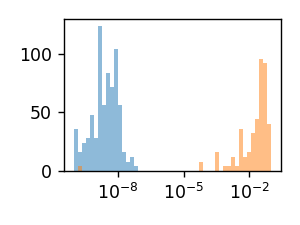

In [28]:
nd_S_0_ao = NumericDiff(gradn, lambda gradh: gradh.S_0_ao).derivative
plot_diff(S_1_ao, nd_S_0_ao)

- `S_1_mo` $S_{pq}^{A_t}$; dim $(A, t, p, q)$ in document, $(A_t, p, q)$ in pyxdh; symm: $S_{pq}^{A_t} = S_{qp}^{A_t}$

$$
S_{pq}^{A_t} = C_{\mu p} S_{\mu \nu}^{A_t} C_{\nu q}
$$

In [29]:
S_1_mo = np.einsum("up, Atuv, vq -> Atpq", C, S_1_ao, C)
S_1_mo.shape

(4, 3, 22, 22)

In [30]:
np.allclose(S_1_mo, S_1_mo.swapaxes(-1, -2))  # symm check

True

In [31]:
np.allclose(S_1_mo, gradh.S_1_mo.reshape(natm, 3, nao, nao))  # pyxdh approach

True

### `H_1_ao` $h_{\mu \nu}^{A_t}$ Hamiltonian Core Skeleton

- `int1e_ipkin` $\langle \partial_t \mu | \hat t | \nu \rangle$; dim: $(t, \mu, \nu)$; symm: $\langle \partial_t \mu | \hat t | \nu \rangle = - \langle \mu | \hat t | \partial_t \nu \rangle$

In [32]:
int1e_ipkin = mol.intor("int1e_ipkin")
int1e_ipkin.shape

(3, 22, 22)

In [33]:
np.allclose(int1e_ipkin, - int1e_ipkin.swapaxes(-1, -2))  # symm check

True

- `int1e_ipkin` $\langle \partial_t \mu | \hat v_\mathrm{nuc} | \nu \rangle$; dim: $(t, \mu, \nu)$; symm: no

In [34]:
int1e_ipnuc = mol.intor("int1e_ipnuc")
int1e_ipnuc.shape

(3, 22, 22)

- `H_1_ao` $h_{\mu \nu}^{A_t}$; dim: $(A, t, \mu, \nu)$ in document, $(A_t, \mu, \nu)$ in pyxdh; symm: $h_{\mu \nu}^{A_t} = h_{\nu \mu}^{A_t}$

$$
h_{\mu \nu}^{A_t} = \frac{\partial}{\partial A_t} h_{\mu \nu} = - \langle \partial_t \mu_A | \hat t | \nu \rangle - \langle \partial_t \mu_A | \hat v_\mathrm{nuc} | \nu \rangle - \langle \partial_t \mu | \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \nu \rangle + \mathrm{swap} (\mu, \nu)
$$

In [35]:
Z_A = mol.atom_charges()
H_1_ao = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    H_1_ao[A, :, sA, :] -= int1e_ipkin[:, sA, :]
    H_1_ao[A, :, sA, :] -= int1e_ipnuc[:, sA, :]
    with mol.with_rinv_as_nucleus(A):
        H_1_ao[A] -= Z_A[A] * mol.intor("int1e_iprinv")
H_1_ao += H_1_ao.swapaxes(-1, -2)
H_1_ao.shape

(4, 3, 22, 22)

In [36]:
np.allclose(H_1_ao, H_1_ao.swapaxes(-1, -2))  # symm check

True

In [37]:
np.allclose(H_1_ao, gradh.H_1_ao.reshape(natm, 3, nao, nao))  # pyxdh approach

True

In [38]:
np.allclose(H_1_ao, np.array([grad.rhf.hcore_generator(scf_eng.nuc_grad_method())(A) for A in range(natm)]))  # PySCF approach

True

<IPython.core.display.Javascript object>


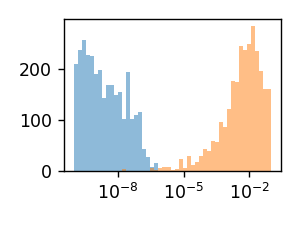

In [39]:
nd_H_0_ao = NumericDiff(gradn, lambda gradh: gradh.H_0_ao).derivative
plot_diff(H_1_ao, nd_H_0_ao)

- `H_1_mo` $h_{pq}^{A_t}$; dim: $(A, t, p, q)$ in document, $(A_t, p, q)$ in pyxdh; symm: $h_{pq}^{A_t} = h_{qp}^{A_t}$

$$
h_{pq}^{A_t} = C_{\mu p} h_{\mu \nu}^{A_t} C_{\nu q}
$$

In [40]:
H_1_mo = np.einsum("up, Atuv, vq -> Atpq", C, H_1_ao, C)
H_1_mo.shape

(4, 3, 22, 22)

In [41]:
np.allclose(H_1_mo, gradh.H_1_mo.reshape(natm, 3, nmo, nmo))  # pyxdh approach

True

### `eri1_ao` $(\mu \nu | \kappa \lambda)^{A_t}$ Electron-repulsion Integral Skeleton

- `int2e_ip1` $(\partial_t \mu \nu | \kappa \lambda)$; dim: $(A, t, \mu, \nu, \kappa, \lambda)$; symm: $(\partial_t \mu \nu | \kappa \lambda) = (\partial_t \mu \nu | \lambda \kappa)$

In [42]:
int2e_ip1 = mol.intor("int2e_ip1")
int2e_ip1.shape

(3, 22, 22, 22, 22)

In [43]:
np.allclose(int2e_ip1, int2e_ip1.swapaxes(-1, -2))  # symm check

True

- `eri1_ao` $(\mu \nu | \kappa \lambda)^{A_t}$; dim: $(A, t, \mu, \nu, \kappa, \lambda)$ in document, $(A_t, \mu, \nu, \kappa, \lambda)$ in pyxdh; symm: $(\mu \nu | \kappa \lambda)^{A_t} = (\mu \nu | \lambda \kappa)^{A_t} = (\kappa \lambda | \mu \nu)^{A_t}$ (8-fold)

$$
\begin{split}\begin{align}
(\mu \nu | \kappa \lambda)^{A_t} = \frac{\partial}{\partial A_t} (\mu \nu | \kappa \lambda) &= - \big[ (\partial_t \mu_A \nu | \kappa \lambda) + (\mu \partial_t \nu_A | \kappa \lambda) + (\mu \nu | \partial_t \kappa_A \lambda) + (\mu \nu | \kappa \partial_t \lambda_A) \big] \\
&= - (\partial_t \mu_A \nu | \kappa \lambda) + \mathrm{swap} (\mu, \nu) + \mathrm{swap} (\mu \nu, \kappa \lambda)
\end{align}\end{split}
$$

In [44]:
eri1_ao = np.zeros((natm, 3, nao, nao, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    eri1_ao[A, :, sA, :, :, :] -= int2e_ip1[:, sA]
eri1_ao += eri1_ao.swapaxes(-3, -4)
eri1_ao += eri1_ao.swapaxes(-1, -3).swapaxes(-2, -4)
eri1_ao.shape

(4, 3, 22, 22, 22, 22)

In [45]:
np.allclose(eri1_ao, eri1_ao.swapaxes(-1, -2))  # symm check

True

In [46]:
np.allclose(eri1_ao, eri1_ao.swapaxes(-3, -4))  # symm check

True

In [47]:
np.allclose(eri1_ao, eri1_ao.swapaxes(-1, -3).swapaxes(-2, -4))  # symm check

True

In [48]:
np.allclose(eri1_ao, gradh.eri1_ao.reshape(natm, 3, nao, nao, nao, nao))  # pyxdh approach

True

<IPython.core.display.Javascript object>


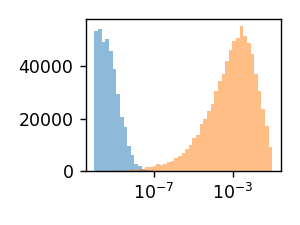

In [49]:
nd_eri0_ao = NumericDiff(gradn, lambda gradh: gradh.eri0_ao).derivative
plot_diff(eri1_ao, nd_eri0_ao)

- `eri1_mo` $(pq|rs)^{A_t}$; dim: $(A, t, p, q, r, s)$ in document, $(A_t, p, q, r, s)$ in pyxdh; symm: $(pq|rs)^{A_t} = (pq|sr)^{A_t} = (rs|pq)^{A_t}$ (8-fold)

$$
(pq|rs)^{A_t} = C_{\mu p} C_{\nu q} (\mu \nu | \kappa \lambda)^{A_t} C_{\kappa r} C_{\lambda s}
$$

In [50]:
eri1_mo = np.einsum("up, vq, Atuvkl, kr, ls -> Atpqrs", C, C, eri1_ao, C, C)
eri1_mo.shape

(4, 3, 22, 22, 22, 22)

In [51]:
np.allclose(eri1_mo, eri1_mo.swapaxes(-1, -2))  # symm check

True

In [52]:
np.allclose(eri1_mo, eri1_mo.swapaxes(-3, -4))  # symm check

True

In [53]:
np.allclose(eri1_mo, eri1_mo.swapaxes(-1, -3).swapaxes(-2, -4))  # symm check

True

In [54]:
np.allclose(eri1_mo, gradh.eri1_mo.reshape(natm, 3, nao, nao, nao, nao))  # pyxdh approach

True

### `A_rho_1` $\rho^{A_t}$ Density Grid Skeleton

- `A_rho_1` $\rho^{A_t}$; dim: $(A, t, g)$

$$
\rho^{A_t} = - 2 \phi_{t \mu_A} \phi_\nu D_{\mu \nu}
$$

In [55]:
A_rho_1 = np.zeros((natm, 3, grdh.ngrid))
for A in range(natm):
    sA = mol_slice(A)
    A_rho_1[A] = - 2 * np.einsum("tgu, gv, uv -> tg", ao_1[:, :, sA], ao_0, D[sA])
A_rho_1.shape

(4, 3, 90600)

In [56]:
np.allclose(A_rho_1, grdh.A_rho_1)  # pyxdh approach

True

### `A_rho_2` $\rho_r^{A_t}$ Density Derivative Grid Skeleton

- `A_rho_2` $\rho_r^{A_t}$; dim: $(A, t, r, g)$

$$
\rho_r^{A_t} = - 2 \phi_{tr \mu_A} \phi_\nu D_{\mu \nu} - 2 \phi_{r \mu} \phi_{t \nu_A} D_{\mu \nu}
$$

In [57]:
A_rho_2 = np.zeros((natm, 3, 3, grdh.ngrid))
for A in range(natm):
    sA = mol_slice(A)
    A_rho_2[A]  = - 2 * np.einsum("trgu, gv, uv -> trg", ao_2[:, :, :, sA], ao_0, D[sA])
    A_rho_2[A] += - 2 * np.einsum("rgu, tgv, uv -> trg", ao_1, ao_1[:, :, sA], D[:, sA])
A_rho_2.shape

(4, 3, 3, 90600)

In [58]:
np.allclose(A_rho_2, grdh.A_rho_2)  # pyxdh approach

True

### `A_gamma_1` $\gamma^{A_t}$ Skeleton

- `A_gamma_1` $\gamma^{A_t}$; dim: $(A, t, g)$

$$
\gamma^{A_t} = 2 \rho_r \rho_r^{A_t}
$$

In [59]:
A_gamma_1 = 2 * np.einsum("rg, Atrg -> Atg", rho_1, A_rho_2)
A_gamma_1.shape

(4, 3, 90600)

In [60]:
np.allclose(A_gamma_1, grdh.A_gamma_1)  # pyxdh approach

True

### `F_1_ao` $F_{\mu \nu}^{A_t}$ (Self-consistent) Fock Skeleton

- `F_1_ao_GGA` $v_{\mu \nu}^\mathrm{xc}$; dim: $(A, t, \mu, \nu)$; symm: $v_{\mu \nu}^\mathrm{xc} = v_{\nu \mu}^\mathrm{xc}$

$$
\begin{align}
\partial_{A_t} v_{\mu \nu}^\mathrm{xc}
&= \frac{1}{2} f_{\rho \rho} \rho^{A_t} \phi_\mu \phi_\nu + \frac{1}{2} f_{\rho \gamma} \gamma^{A_t} \phi_\mu \phi_\nu \\
&\quad + 2 f_{\rho \gamma} \rho^{A_t} \rho_r \phi_{r \mu} \phi_{\nu} + 2 f_{\gamma \gamma} \gamma^{A_t} \rho_r \phi_{r \mu} \phi_{\nu} \\
&\quad + 2 f_\gamma \rho_r^{A_t} \phi_{r \mu} \phi_{\nu} \\
&\quad - f_\rho \phi_{t \mu_A} \phi_\nu - 2 f_\gamma \rho_r \phi_{tr \mu_A} \phi_{\nu} - 2 f_\gamma \rho_r \phi_{t \mu_A} \phi_{r \nu}
\end{align}
$$

In [61]:
F_1_ao_GGA = (
    + 0.5 * np.einsum("g, Atg, gu, gv -> Atuv", kerh.frr, A_rho_1, ao_0, ao_0)
    + 0.5 * np.einsum("g, Atg, gu, gv -> Atuv", kerh.frg, A_gamma_1, ao_0, ao_0)
    + 2 * np.einsum("g, Atg, rg, rgu, gv -> Atuv", kerh.frg, A_rho_1, rho_1, ao_1, ao_0)
    + 2 * np.einsum("g, Atg, rg, rgu, gv -> Atuv", kerh.fgg, A_gamma_1, rho_1, ao_1, ao_0)
    + 2 * np.einsum("g, Atrg, rgu, gv -> Atuv", kerh.fg, A_rho_2, ao_1, ao_0)
)
for A in range(natm):
    sA = mol_slice(A)
    F_1_ao_GGA[A, :, sA, :] -= np.einsum("g, tgu, gv -> tuv", kerh.fr, ao_1[:, :, sA], ao_0)
    F_1_ao_GGA[A, :, sA, :] -= 2 * np.einsum("g, rg, trgu, gv -> tuv", kerh.fg, rho_1, ao_2[:, :, :, sA], ao_0)
    F_1_ao_GGA[A, :, sA, :] -= 2 * np.einsum("g, rg, tgu, rgv -> tuv", kerh.fg, rho_1, ao_1[:, :, sA], ao_1)
F_1_ao_GGA += F_1_ao_GGA.swapaxes(-1, -2)  # swap (u, v)
F_1_ao_GGA.shape

(4, 3, 22, 22)

In [62]:
np.allclose(F_1_ao_GGA, F_1_ao_GGA.swapaxes(-1, -2))  # symm check

True

- `F_1_ao` $F_{\mu \nu}^{A_t}$; dim: $(A, t, \mu, \nu)$ in document, $(A_t, \mu, \nu)$ in pyxdh; symm: $F_{\mu \nu}^{A_t} = F_{\nu \mu}^{A_t}$

$$
F_{\mu \nu}^{A_t} = h_{\mu \nu}^{A_t} + (\mu \nu | \kappa \lambda)^{A_t} D_{\kappa \lambda} - \frac{c_\mathrm{x}}{2} (\mu \kappa | \nu \lambda)^{A_t} D_{\kappa \lambda} + v_{\mu \nu}^{\mathrm{xc}, A_t}
$$

In [63]:
F_1_ao = (
    + H_1_ao
    + np.einsum("Atuvkl, kl -> Atuv", eri1_ao, D)
    - 0.5 * cx * np.einsum("Atukvl, kl -> Atuv", eri1_ao, D)
    + F_1_ao_GGA
)
F_1_ao.shape

(4, 3, 22, 22)

In [64]:
np.allclose(F_1_ao, F_1_ao.swapaxes(-1, -2))  # symm check

True

In [65]:
np.allclose(F_1_ao, gradh.F_1_ao.reshape(natm, 3, nao, nao))  # pyxdh approach

True

In [66]:
np.allclose(F_1_ao, np.array(hessian.rks.Hessian(scf_eng).make_h1(C, gradh.mo_occ)))  # PySCF approach

True

- `F_1_mo` $F_{pq}^{A_t}$; dim: $(A, t, p, q)$ in document, $(A_t, p, q)$ in pyxdh; summ: $F_{pq}^{A_t} = F_{qp}^{A_t}$

$$
F_{pq}^{A_t} = C_{\mu p} F_{\mu \nu}^{A_t} C_{\nu q}
$$

In [67]:
F_1_mo = np.einsum("up, Atuv, vq -> Atpq", C, F_1_ao, C)
F_1_mo.shape

(4, 3, 22, 22)

In [68]:
np.allclose(F_1_mo, F_1_mo.swapaxes(-1, -2))  # symm check

True

In [69]:
np.allclose(F_1_mo, gradh.F_1_mo.reshape(natm, 3, nmo, nmo))  # pyxdh approach

True

### `Ax0_Core` $A_{pq, rs}$ (Self-consistent) A Tensor (G Response) Contraction

- `Ax0_Core` $A_{pq, rs}$ tensor contraction: input $X_{rs}^\mathbb{A}$ $(\mathbb{A}, r, s)$, output $A_{pq, rs} X_{rs}^\mathbb{A}$ $(\mathbb{A}, p, q)$, where here $p, q, r, s$ does not necessarily mean all molecular orbitals

- function initialization `sp, sq, sr, ss` orbital slice of $p, q, r, s$

    - `dmX` $X_{\kappa \lambda}^\mathbb{A} = C_{\kappa r} X_{rs}^\mathbb{X} C_{\lambda} + \mathrm{swap} (\kappa, \lambda)$; dim $(\mathbb{A}, \kappa, \lambda)$
    
    - `rho_X_0` $\varrho^\mathbb{A} = X_{\kappa \lambda}^\mathbb{A} \phi_\kappa \phi_\lambda$; dim $(\mathbb{A}, g)$
    
    - `rho_X_1` $\varrho_r^\mathbb{A} = 2 X_{\kappa \lambda}^\mathbb{A} \phi_{r \kappa} \phi_\lambda$; dim $(\mathbb{A}, r, g)$
    
    - `gamma_XD` $\varrho_w^\mathbb{A} \rho_w$, index $w$ summed; dim $(\mathbb{A}, g)$
    
    - `M_0` $M^\mathbb{A} = f_{\rho \rho} \varrho^\mathbb{A} + f_{\rho \gamma} (\varrho_w^\mathbb{A} \rho_w)$; dim $(\mathbb{A}, g)$
    
    - `M_1` $M_r^\mathbb{A} = 4 f_{\rho \gamma} \varrho^\mathbb{A} \rho_r + 8 f_{\rho \gamma} (\varrho_w^\mathbb{A} \rho_w) \rho_r + 4 f_\gamma \varrho_r^\mathbb{A}$; dim $(\mathbb{A}, r, g)$
    
    - `ax_ao` $A_{\mu \nu, \kappa \lambda} X_{\mu \nu}^\mathbb{A}$; dim $(\mathbb{A}, \mu, \nu)$
    
        $$
        A_{\mu \nu, \kappa \lambda} X_{\mu \nu}^\mathbb{A} = (\mu \nu | \kappa \lambda) X_{\kappa \lambda}^\mathbb{A} - \frac{c_\mathrm{x}}{2} (\mu \kappa | \nu \lambda) X_{\kappa \lambda}^\mathbb{A} + M^\mathbb{A} \phi_\mu \phi_\nu + M_r^\mathbb{A} \phi_{r \mu} \phi_\nu + \mathrm{swap} (\mu, \nu)
        $$
    
    - `ax_mo` $A_{pq, rs} X_{rs}^\mathbb{A}$; dim $(\mathbb{A}, p, q)$

In [70]:
def Ax0_Core(sp, sq, sr, ss):
    def fx(X):
        X_ = X.view().reshape(-1, X.shape[-2], X.shape[-1])
        dmX = C[:, sr] @ X_ @ C[:, ss].T
        dmX += dmX.swapaxes(-1, -2)
        tmp_K = np.einsum("Akl, gl -> Agk", dmX, ao_0)
        rho_X_0 = np.einsum("gk, Agk -> Ag", grdh.ao_0, tmp_K)
        rho_X_1 = 2 * np.einsum("rgk, Agk -> Arg", grdh.ao_1, tmp_K)
        gamma_XD = np.einsum("Arg, rg -> Ag", rho_X_1, rho_1)
        M_0 = (
            np.einsum("g, Ag -> Ag", kerh.frr, rho_X_0)
            + 2 * np.einsum("g, Ag -> Ag", kerh.frg, gamma_XD)
        )
        M_1 = (
            + 4 * np.einsum("g, Ag, rg -> Arg", kerh.frg, rho_X_0, rho_1)
            + 8 * np.einsum("g, Ag, rg -> Arg", kerh.fgg, gamma_XD, rho_1)
            + 4 * np.einsum("g, Arg -> Arg", kerh.fg, rho_X_1)
        )
        ax_ao = (
            + 1 * np.einsum("uvkl, Akl -> Auv", eri0_ao, dmX)
            - 0.5 * cx * np.einsum("ukvl, Akl -> Auv", eri0_ao, dmX)
            + np.einsum("Ag, gu, gv -> Auv", M_0, ao_0, ao_0)
            + np.einsum("Arg, rgu, gv -> Auv", M_1, ao_1, ao_0)
        )
        ax_ao += ax_ao.swapaxes(-1, -2)
        ax_mo = C[:, sp].T @ ax_ao @ C[:, sq]
        X_shape = list(X.shape)
        X_shape[-2:] = ax_mo.shape[-2:]
        return ax_mo.reshape(X_shape)
    return fx

In [71]:
X = np.random.randn(4, 5, nmo, nocc)

In [72]:
Ax0_Core(sv, so, sa, so)(X).shape

(4, 5, 13, 9)

In [73]:
np.allclose(Ax0_Core(sv, so, sa, so)(X), gradh.Ax0_Core(sv, so, sa, so)(X))  # pyxdh approach

True

In [74]:
np.allclose(
    Ax0_Core(sv, so, sa, so)(X),
    hessian.rhf.gen_vind(scf_eng, C, gradh.mo_occ)(X.reshape(-1, nmo, nocc)).reshape(4, 5, nmo, nocc)[:, :, sv, so]
)  # PySCF approach

True

### `B_1` $B_{pq}^{A_t}$ B Matrix (CP-HF Equation RHS)

- `B_1` $B_{pq}^{A_t}$; dim: $(A, t, p, q)$ in document, $(A_t, p, q)$ in pyxdh; symm: no

$$
B_{pq}^{A_t} = F_{pq}^{A_t} - S_{pq}^{A_t} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^{A_t}
$$

In [75]:
B_1 = (
    + F_1_mo
    - np.einsum("Atpq, q -> Atpq", S_1_mo, e)
    - 0.5 * Ax0_Core(sa, sa, so, so)(S_1_mo[:, :, so, so])
)
B_1.shape

(4, 3, 22, 22)

In [76]:
np.allclose(B_1, gradh.B_1.reshape(natm, 3, nmo, nmo))  # pyxdh approach

True

### `U_1_vo` $U_{ai}^{A_t}$ U Matrix Virt-Occ Block (Unnecessary for xDH Gradient)

- `U_1_vo` $U_{ai}^{A_t}$; dim: $(A, t, p, q)$ in document, $(A_t, p, q)$ in pyxdh

$$
- (\varepsilon_a - \varepsilon_i) U_{ai}^{A_t} - A_{ai, bj} U_{bj}^{A_t} = B_{ai}^{A_t}
$$

In [77]:
U_1_vo = cphf.solve(
    Ax0_Core(sv, so, sv, so),
    e,
    gradh.mo_occ,
    B_1[:, :, sv, so].reshape(-1, nvir, nocc),
    tol=1e-12,
)[0].reshape(natm, 3, nvir, nocc)
U_1_vo.shape

(4, 3, 13, 9)

In [78]:
np.allclose(
    B_1[:, :, sv, so] + (ev[:, None] - eo[None, :]) * U_1_vo + Ax0_Core(sv, so, sv, so)(U_1_vo),
    np.zeros((natm, 3, nvir, nocc))
)  # check sanity by CP-HF equation

True

<IPython.core.display.Javascript object>


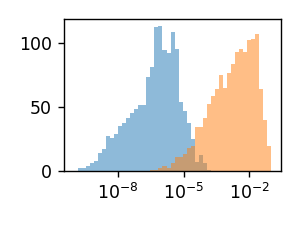

In [79]:
nd_C = NumericDiff(gradn, lambda gradh: gradh.C).derivative.reshape((natm, 3, nao, nao))
nd_U_1_vo = np.einsum("mu, Atup -> Atmp", np.linalg.inv(C), nd_C)[:, :, sv, so]
plot_diff(U_1_vo, nd_U_1_vo)

### PT2 Tensors

- `D_iajb` $D_{ij}^{ab}$; dim: $(i, a, j, b)$; symm: $D_{ij}^{ab} = D_{ji}^{ab} = D_{ij}^{ba}$ (4-fold)

$$
D_{ij}^{ab} = \varepsilon_i - \varepsilon_a + \varepsilon_j - \varepsilon_b
$$

In [80]:
D_iajb = eo[:, None, None, None] - ev[None, :, None, None] + eo[None, None, :, None] - ev[None, None, None, :]
D_iajb.shape

(9, 13, 9, 13)

In [81]:
np.allclose(D_iajb, D_iajb.swapaxes(-1, -3))  # symm check

True

In [82]:
np.allclose(D_iajb, D_iajb.swapaxes(-2, -4))  # symm check

True

- `t_iajb` $t_{ij}^{ab}$; dim: $(i, a, j, b)$; symm: $t_{ij}^{ab} = t_{ji}^{ba}$

$$
t_{ij}^{ab} = (ia|jb) / D_{ij}^{ab}
$$

In [83]:
t_iajb = eri0_mo[so, sv, so, sv] / D_iajb
t_iajb.shape

(9, 13, 9, 13)

In [84]:
np.allclose(t_iajb, t_iajb.swapaxes(-1, -3).swapaxes(-2, -4))  # symm check

True

- `T_iajb` $T_{ij}^{ab}$; dim: $(i, a, j, b)$; symm: $T_{ij}^{ab} = T_{ji}^{ba}$

$$
T_{ij}^{ab} = c_\mathrm{c}^\mathrm{n} (2 t_{ij}^{ab} - t_{ij}^{ba})
$$

In [85]:
T_iajb = cc * (2 * t_iajb - t_iajb.swapaxes(-1, -3))
T_iajb.shape

(9, 13, 9, 13)

In [86]:
np.allclose(T_iajb, T_iajb.swapaxes(-1, -3).swapaxes(-2, -4))  # symm check

True

- Energy check: $E_\mathrm{PT2} = T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab}$

In [87]:
np.einsum("iajb, iajb, iajb -> ", T_iajb, t_iajb, D_iajb)

-0.46171070585999907

In [88]:
gradh.eng - gradh.nc_deriv.scf_eng.energy_tot(dm=D)

-0.46171070585998564

### `W_I` $W_{pq}^\mathrm{PT2} [\mathrm{I}]$ Part I of Weighted Density Matrix

- `W_I` $W_{pq}^\mathrm{PT2} [\mathrm{I}]$; dim: $(p, q)$; symm: no

$$
\begin{align}
W_{ij}^\mathrm{PT2} [\mathrm{I}] &= - 2 T_{ik}^{ab} (ja|kb) \\
W_{ab}^\mathrm{PT2} [\mathrm{I}] &= - 2 T_{ij}^{ac} (ib|jc) \\
W_{ai}^\mathrm{PT2} [\mathrm{I}] &= - 4 T_{jk}^{ab} (ij|bk) \\
W_{ia}^\mathrm{PT2} [\mathrm{I}] &= 0
\end{align}
$$

In [89]:
W_I = np.zeros((nmo, nmo))
W_I = np.zeros((nmo, nmo))
W_I[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, eri0_mo[so, sv, so, sv])
W_I[sv, sv] = - 2 * np.einsum("iajc, ibjc -> ab", T_iajb, eri0_mo[so, sv, so, sv])
W_I[sv, so] = - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, eri0_mo[so, so, sv, so])
W_I.shape

(22, 22)

### `D_r` $D_{pq}^\mathrm{PT2+}$ Relaxed Density Matrix: Block-Diagonal Part

- `D_r` $D_{pq}^\mathrm{PT2+}$; dim: $(p, q)$ (pre-definition); actual total symm: no

In [90]:
D_r = np.zeros((nmo, nmo))

- `D_r[so, so]` $D_{ij}^\mathrm{PT2+}$; dim: $(i, j)$; symm: $D_{ij}^\mathrm{PT2+} = D_{ji}^\mathrm{PT2+}$

$$
D_{ij}^\mathrm{PT2+} = - 2 T_{ik}^{ab} t_{jk}^{ab}
$$

In [91]:
D_r[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)

In [92]:
np.allclose(D_r[so, so], D_r[so, so].T)  # symm check

True

- `D_r[sv, sv]` $D_{ab}^\mathrm{PT2+}$; dim: $(a, b)$; symm: $D_{ab}^\mathrm{PT2+} = D_{ba}^\mathrm{PT2+}$

$$
D_{ab}^\mathrm{PT2+} = 2 T_{ij}^{ac} t_{ij}^{bc}
$$

In [93]:
D_r[sv, sv] = 2 * np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)

In [94]:
np.allclose(D_r[sv, sv], D_r[sv, sv].T)  # symm check

True

### `L` $L_{ai}^\mathrm{PT2+}$ PT2+ Total Lagrangian

- `L` $L_{ai}^\mathrm{PT2+}$; dim $(a, i)$

$$
L_{ai}^\mathrm{PT2+} = A_{ai, kl} D_{kl}^\mathrm{PT2} + A_{ai, bc} D_{bc}^\mathrm{PT2} - 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc) + 4 F_{ai}^\mathrm{n}
$$

Up to now, `D_r` only contains occ-occ and vir-vir block, so technically we can just use `D_r` to generate `L`. Reason of introducing term $4 F_{ai}^\mathrm{n}$ has been stated previously in this section.

In [95]:
L = (
    + Ax0_Core(sv, so, sa, sa)(D_r)
    - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, eri0_mo[so, so, sv, so])
    + 4 * np.einsum("ibjc, abjc -> ai", T_iajb, eri0_mo[sv, sv, so, sv])
    + 4 * nc_F_0_mo[sv, so]
)

In [96]:
np.allclose(L, gradh.L)  # pyxdh approach

True

### `D_r` $D_{pq}^\mathrm{PT2+}$ Relaxed Density Matrix: vir-occ Part

- `D_r[sv, so]` $D_{ai}^\mathrm{PT2+}$; dim: $(a, i)$

$$
- (\varepsilon_a - \varepsilon_i) D_{ai}^\mathrm{PT2+} - A_{ai, bj} D_{bj}^\mathrm{PT2+} = L_{ai}^\mathrm{PT2+}
$$

In [97]:
D_r[sv, so] = cphf.solve(Ax0_Core(sv, so, sv, so), e, gradh.mo_occ, L, tol=1e-12, max_cycle=100)[0]

In [98]:
np.allclose(
    L + (ev[:, None] - eo[None, :]) * D_r[sv, so] + Ax0_Core(sv, so, sv, so)(D_r[sv, so]),
    np.zeros((nvir, nocc))
)  # check sanity by CP-HF equation

True

In [99]:
np.allclose(D_r, gradh.D_r)  # pyxdh approach

True

### `E_1_nuc` $\partial_{A_t} E_\mathrm{nuc}$ Nucleus Repulsion Energy Derivative

- `nuc_Z` $Z_{AB}$; dim: $(A, B)$; symm: $Z_{AB} = Z_{BA}$

$$
Z_{AB} = Z_A Z_B
$$

In [100]:
nuc_Z = np.einsum("A, B -> AB", mol.atom_charges(), mol.atom_charges())
nuc_Z.shape

(4, 4)

In [101]:
np.allclose(nuc_Z, nuc_Z.swapaxes(0, 1))

True

- `nuc_V` $V_{ABt}$; dim: $(A, B, t)$; symm: $V_{ABt} = - V_{BAt}$

$$
V_{ABt} = A_t - B_t
$$

In [102]:
nuc_V = lib.direct_sum("Mt - Nt -> MNt", mol.atom_coords(), mol.atom_coords())
nuc_V.shape

(4, 4, 3)

In [103]:
np.allclose(nuc_V, - nuc_V.swapaxes(0, 1))

True

- `nuc_rinv` $r_{AB}^{-1}$; dim: $(A, B)$; symm: $r_{AB}^{-1} = r_{BA}^{-1}$

$$
r_{AB}^{-1} = \left\{
\begin{matrix}
| \boldsymbol{A} - \boldsymbol{B} |^{-1}, & \quad A \neq B \\
0, & \quad A = B
\end{matrix}
\right.
$$

In [104]:
nuc_rinv = 1 / (np.linalg.norm(nuc_V, axis=2) + np.diag([np.inf] * natm))
nuc_rinv.shape

(4, 4)

- `E_1_nuc` $\partial_{A_t} E_\mathrm{nuc}$; dim: $(A, t)$

$$
\partial_{A_t} E_\mathrm{nuc} = - \sum_M Z_{AM} r_{AM}^{-3} V_{AMt}
$$

In [105]:
E_1_nuc = - np.einsum("AM, AM, AMt -> At", nuc_Z, nuc_rinv**3, nuc_V)
E_1_nuc

array([[ 0.99566,  0.34575,  8.70615],
       [ 0.35202,  4.57189, -8.31727],
       [-1.38536,  0.01759,  0.3897 ],
       [ 0.03768, -4.93523, -0.77858]])

### `E_1` $\partial E_\mathrm{tot}$ Total XYG3 Energy Derivative

- `E_1` $\partial E_\mathrm{tot}$; dim: $(A, t)$

$$
\begin{align}
\partial_{A_t} E_\mathrm{tot}
&= h_{\mu \nu}^{A_t} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda)^{A_t} D_{\kappa \lambda} - \frac{c_\mathrm{x}^\mathrm{n}}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda)^{A_t} D_{\kappa \lambda} + f_\rho^\mathrm{n} \rho^{A_t} + f_\gamma^\mathrm{n} \gamma^{A_t} - 2 S_{ij}^{A_t} F_{ij}^\mathrm{n} \\
&\quad + D_{pq}^\mathrm{PT2+} B_{pq}^{A_t} + W_{pq}^\mathrm{PT2} [\mathrm{I}] S_{pq}^{A_t} + 2 T_{ij}^{ab} (ia|jb)^{A_t} + \partial_{A_t} E_\mathrm{nuc}
\end{align}
$$

In [106]:
E_1 = (
    # Line 1
    + np.einsum("Atuv, uv -> At", H_1_ao, D)
    + 0.5 * np.einsum("uv, Atuvkl, kl -> At", D, eri1_ao, D)
    - 0.25 * cx_n * np.einsum("uv, Atukvl, kl -> At", D, eri1_ao, D)
    + np.einsum("g, Atg -> At", kerh_n.fr, A_rho_1)
    + np.einsum("g, Atg -> At", kerh_n.fg, A_gamma_1)
    - 2 * np.einsum("Atij, ij -> At", S_1_mo[:, :, so, so], nc_F_0_mo[so, so])
    # Line 2
    + np.einsum("pq, Atpq -> At", D_r, B_1)
    + np.einsum("pq, Atpq -> At", W_I, S_1_mo)
    + 2 * np.einsum("iajb, Atiajb -> At", T_iajb, eri1_mo[:, :, so, sv, so, sv])
    + E_1_nuc
)
E_1

array([[-0.02771,  0.0094 ,  0.11209],
       [ 0.00749,  0.77869, -0.09944],
       [ 0.01601,  0.00197,  0.0117 ],
       [ 0.00422, -0.79005, -0.02435]])

In [107]:
np.allclose(E_1, gradh.E_1)  # pyxdh approach

True

In [108]:
nd_E_0 = NumericDiff(gradn, lambda gradh: gradh.eng).derivative
np.allclose(E_1, nd_E_0.reshape(natm, 3), rtol=2e-4)  # numerical derivative check

True